# Kyle Calabro
# DATA 750 - Thesis in Data Science
---

# Notebook Nine:
---
## Deploy transfer learning models with fine-tuning on the augmented training data, evaluate performance on testing data

In [ ]:
import librosa
import librosa.display

%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib.pyplot import specgram

import seaborn as sns

import IPython.display as ipd
from IPython.display import Audio

import seaborn as sns

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import sys
import warnings
import re

import time
import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, AveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, InputLayer, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import vgg16, vgg19, InceptionV3, Xception, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

from google.colab import drive
drive.mount("/content/drive")

# To ignore deprecation warnings...
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

np.random.seed(42)
#tf.random.set_random_seed(42)

Mounted at /content/drive


# Utility Functions
---

In [ ]:
# To plot the accuracy of a CNN across epochs

def plot_accuracy(model_hist, model_title):
    plt.plot(model_hist.history["accuracy"])
    plt.plot(model_hist.history["val_accuracy"])
    plt.plot(figsize = (16, 16))
    plt.grid(True)
    plt.title(model_title)
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc = "best")
    plt.show();

In [ ]:
# To plot the loss of a CNN across epochs

def plot_loss(model_hist, model_title):
    plt.plot(model_hist.history["loss"])
    plt.plot(model_hist.history["val_loss"])
    plt.plot(figsize = (16, 16))
    plt.grid(True)
    plt.title(model_title)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(['Train', 'Test'], loc = "best")
    plt.show();

In [ ]:
# To get the predicted labels of a given CNN model
# Params:
    # X_test: features from the test set data
    # model: the CNN model to make predictions with
    # encoder: The label encoder object used to encode labels initially

def get_predictions(X_test, model, encoder):
    y_pred = model.predict(X_test)
    y_pred = y_pred.argmax(axis = 1)
    y_pred = y_pred.astype(int).flatten()
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred

In [ ]:
# To get the actual labels of a given CNN model
# Params:
    # y_test: target variable from the test set
    # encoder: The label encoder object used to encode labels initially

def get_labels(y_test, encoder):
    labels = y_test.argmax(axis = 1)
    labels = labels.astype(int).flatten()
    labels = encoder.inverse_transform(labels)
    return labels

In [ ]:
# To print a classification report based on predictions from a CNN 
# and provided actual labels
# Params:
    # labels: The actual labels of the target variable
    # y_pred: The predicted labels of the target variable
    # encoder: The label encoder object used to encode labels initially
    
def get_report(labels, y_pred, encoder):
    target_names = encoder.classes_
    print(classification_report(labels, y_pred, target_names))

# Bringing in the Data
----

In [ ]:
regex = re.compile(r"\d+")

In [ ]:
train_files = glob.glob("/content/drive/My Drive/Thesis/Aug_Train/*.jpeg")

train_metadata = pd.read_csv("/content/drive/My Drive/Thesis/Aug_Train/aug_train.csv")
train_metadata.columns.values[0] = "corresponding_id"

train_imgs = [img_to_array(load_img(img)) for img in train_files]
train_imgs = np.array(train_imgs)

index_list = [regex.findall(file)[0] for file in train_files]
index_list = list(map(int, index_list))

train_labels = [train_metadata.Emotion.iloc[index] for index in index_list]

In [ ]:
test_files = glob.glob("/content/drive/My Drive/Thesis/Orig_Test/*.jpeg")

test_metadata = pd.read_csv("/content/drive/My Drive/Thesis/Orig_Test/orig_test_data.csv")
test_metadata.columns.values[0] = "corresponding_id"

test_imgs = [img_to_array(load_img(img)) for img in test_files]
test_imgs = np.array(test_imgs)

index_list = [regex.findall(file)[0] for file in test_files]
index_list = list(map(int, index_list))

test_labels = [test_metadata.Emotion.iloc[index] for index in index_list]

In [ ]:
print("Training Dataset Shape:", train_imgs.shape)

Training Dataset Shape: (9216, 217, 334, 3)


In [ ]:
print("Testing Dataset Shape:", test_imgs.shape)

Testing Dataset Shape: (288, 217, 334, 3)


In [ ]:
print("Number of Training Labels:", len(train_labels))

Number of Training Labels: 9216


In [ ]:
print("Number of Testing Labels:", len(test_labels))

Number of Testing Labels: 288


In [ ]:
train_imgs_scaled = train_imgs.astype("float32")
train_imgs_scaled /= 255

test_imgs_scaled = test_imgs.astype("float32")
test_imgs_scaled /= 255

(217, 334, 3)


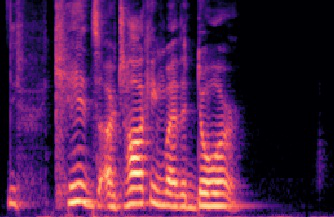

In [ ]:
print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [ ]:
# One-hot encoding
encoder = LabelEncoder()

y_train = to_categorical(encoder.fit_transform(train_labels))
y_test = to_categorical(encoder.fit_transform(test_labels))

In [ ]:
print(encoder.classes_)

['Angry' 'Calm' 'Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Surprise']


# VGG-16 Model Deployment with Fine-Tuning
---

In [ ]:
vgg = vgg16.VGG16(include_top = False, weights = "imagenet", input_shape = train_imgs[0].shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = True
set_trainable = False

for layer in vgg_model.layers:
    if layer.name in ["block5_conv1", "block4_conv1"]:
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns = ["Layer Type", "Layer Name", "Layer Trainable"])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


### Last two convolutional blocks of the VGG-16 model are unfrozen, weights will change during training

In [ ]:
model = Sequential()
input_shape = vgg_model.output_shape[1]

model.add(vgg_model)
model.add(Dense(512, activation = "relu", input_dim = input_shape))
model.add(Dropout(.3))
model.add(Dense(512, activation = "relu"))
model.add(Dropout(.3))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(.3))
model.add(Dense(8, activation = "softmax"))

model.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 30720)             14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               15729152  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_1 = time.time()

model_1_hist = model.fit(x = train_imgs_scaled, y = y_train, batch_size = 32, epochs = 30, validation_data = (test_imgs_scaled, y_test), verbose = 1)

end_time_model_1 = time.time()

Epoch 1/30
288/288 [==============================] - 836s 3s/step - loss: 1.7480 - accuracy: 0.3409 - val_loss: 1.2886 - val_accuracy: 0.5104
Epoch 2/30
288/288 [==============================] - 799s 3s/step - loss: 1.2143 - accuracy: 0.5558 - val_loss: 1.0529 - val_accuracy: 0.6319
Epoch 3/30
288/288 [==============================] - 788s 3s/step - loss: 0.9079 - accuracy: 0.6801 - val_loss: 0.8223 - val_accuracy: 0.7118
Epoch 4/30
288/288 [==============================] - 796s 3s/step - loss: 0.6669 - accuracy: 0.7597 - val_loss: 0.7263 - val_accuracy: 0.7708
Epoch 5/30
288/288 [==============================] - 789s 3s/step - loss: 0.4759 - accuracy: 0.8345 - val_loss: 0.6897 - val_accuracy: 0.7986
Epoch 6/30
288/288 [==============================] - 799s 3s/step - loss: 0.3475 - accuracy: 0.8800 - val_loss: 0.6143 - val_accuracy: 0.8264
Epoch 7/30
288/288 [==============================] - 797s 3s/step - loss: 0.2551 - accuracy: 0.9119 - val_loss: 0.7117 - val_accuracy: 0.8090

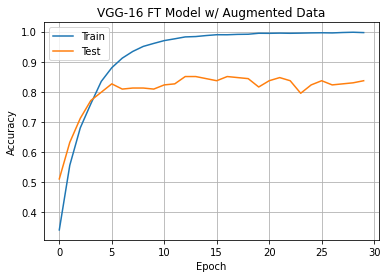

In [ ]:
plot_accuracy(model_1_hist, "VGG-16 FT Model w/ Augmented Data")

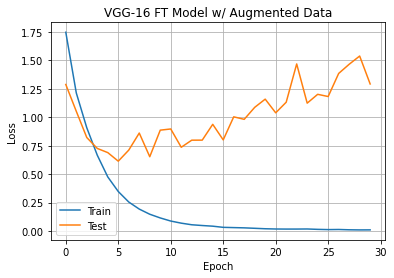

In [ ]:
plot_loss(model_1_hist, "VGG-16 FT Model w/ Augmented Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_1 - start_time_model_1), "\n")

Elapsed Training Time: 24203.61504817009 seconds 



In [ ]:
model.evaluate(test_imgs_scaled, y_test)

9/9 [==============================] - 12s 1s/step - loss: 1.2932 - accuracy: 0.8368


[1.293164610862732, 0.8368055820465088]

In [ ]:
y_pred_model_1 = get_predictions(test_imgs_scaled, model, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_1, encoder)

              precision    recall  f1-score   support

       Angry       0.79      0.77      0.78        35
        Calm       0.81      0.94      0.87        36
     Disgust       0.79      0.87      0.83        39
        Fear       0.91      0.80      0.85        40
       Happy       0.85      0.78      0.81        36
     Neutral       0.88      0.88      0.88        24
         Sad       0.76      0.68      0.72        38
    Surprise       0.91      0.97      0.94        40

    accuracy                           0.84       288
   macro avg       0.84      0.84      0.84       288
weighted avg       0.84      0.84      0.84       288



In [ ]:
model.save("/content/drive/My Drive/Thesis/VGG16_FT_Aug_Data.h5")

# VGG-19 Model Deployment with Fine Tuning
---

In [ ]:
vgg_19 = vgg19.VGG19(include_top = False, weights = "imagenet", input_shape = train_imgs[0].shape)

output = vgg_19.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_19_model = Model(vgg_19.input, output)

vgg_19_model.trainable = True
set_trainable = False

for layer in vgg_19_model.layers:
    if layer.name in ["block5_conv1", "block4_conv1"]:
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in vgg_19_model.layers]
pd.DataFrame(layers, columns = ["Layer Type", "Layer Name", "Layer Trainable"])   

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_1,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
3,<keras.layers.pooling.MaxPooling2D object at 0...,block1_pool,False
4,<keras.layers.convolutional.Conv2D object at 0...,block2_conv1,False
5,<keras.layers.convolutional.Conv2D object at 0...,block2_conv2,False
6,<keras.layers.pooling.MaxPooling2D object at 0...,block2_pool,False
7,<keras.layers.convolutional.Conv2D object at 0...,block3_conv1,False
8,<keras.layers.convolutional.Conv2D object at 0...,block3_conv2,False
9,<keras.layers.convolutional.Conv2D object at 0...,block3_conv3,False


In [ ]:
model_3 = Sequential()
input_shape = vgg_19_model.output_shape[1]

model_3.add(vgg_19_model)
model_3.add(Dense(512, activation = "relu", input_dim = input_shape))
model_3.add(Dropout(.3))
model_3.add(Dense(512, activation = "relu"))
model_3.add(Dropout(.3))
model_3.add(Dense(256, activation = "relu"))
model_3.add(Dropout(.3))
model_3.add(Dense(8, activation = "softmax"))

model_3.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])
model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 30720)             20024384  
_________________________________________________________________
dense (Dense)                (None, 512)               15729152  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_3 = time.time()

model_3_hist = model_3.fit(x = train_imgs_scaled, y = y_train, batch_size = 32, epochs = 30, validation_data = (test_imgs_scaled, y_test), verbose = 1)

end_time_model_3 = time.time()

Epoch 1/30
288/288 [==============================] - 1081s 4s/step - loss: 1.7957 - accuracy: 0.3120 - val_loss: 1.3092 - val_accuracy: 0.5069
Epoch 2/30
288/288 [==============================] - 1086s 4s/step - loss: 1.2973 - accuracy: 0.5238 - val_loss: 1.0110 - val_accuracy: 0.6458
Epoch 3/30
288/288 [==============================] - 1083s 4s/step - loss: 0.9687 - accuracy: 0.6487 - val_loss: 0.8793 - val_accuracy: 0.6875
Epoch 4/30
288/288 [==============================] - 1079s 4s/step - loss: 0.7303 - accuracy: 0.7402 - val_loss: 0.7628 - val_accuracy: 0.7465
Epoch 5/30
288/288 [==============================] - 1081s 4s/step - loss: 0.5430 - accuracy: 0.8087 - val_loss: 0.7085 - val_accuracy: 0.7674
Epoch 6/30
288/288 [==============================] - 1081s 4s/step - loss: 0.3984 - accuracy: 0.8583 - val_loss: 0.8897 - val_accuracy: 0.7396
Epoch 7/30
288/288 [==============================] - 1091s 4s/step - loss: 0.3000 - accuracy: 0.8993 - val_loss: 0.7196 - val_accuracy:

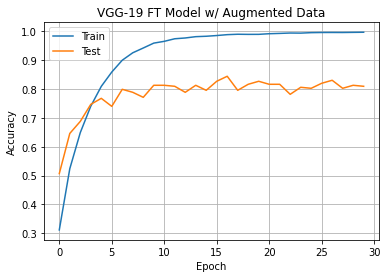

In [ ]:
plot_accuracy(model_3_hist, "VGG-19 FT Model w/ Augmented Data")

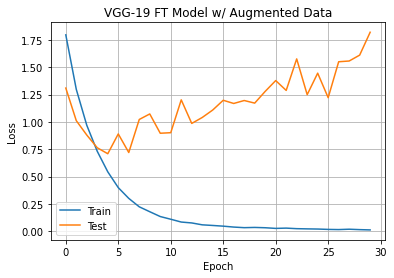

In [ ]:
plot_loss(model_3_hist, "VGG-19 FT Model w/ Augmented Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_3 - start_time_model_3), "\n")

Elapsed Training Time: 32382.33244585991 seconds 



In [ ]:
model_3.evaluate(test_imgs_scaled, y_test)

9/9 [==============================] - 18s 2s/step - loss: 1.8197 - accuracy: 0.8090


[1.8197263479232788, 0.8090277910232544]

In [ ]:
y_pred_model_3 = get_predictions(test_imgs_scaled, model_3, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_3, encoder)

              precision    recall  f1-score   support

       Angry       0.70      0.89      0.78        35
        Calm       0.72      0.92      0.80        36
     Disgust       0.87      0.85      0.86        39
        Fear       0.86      0.78      0.82        40
       Happy       0.79      0.83      0.81        36
     Neutral       0.86      0.75      0.80        24
         Sad       0.83      0.53      0.65        38
    Surprise       0.90      0.93      0.91        40

    accuracy                           0.81       288
   macro avg       0.82      0.81      0.80       288
weighted avg       0.82      0.81      0.81       288



In [ ]:
model_3.save("/content/drive/My Drive/Thesis/VGG19_FT_Aug_Data.h5")

# InceptionV3 Model Deployment with Fine Tuning
---

In [ ]:
inception = InceptionV3(weights = "imagenet", include_top = False, input_shape = train_imgs[0].shape)

output = inception.layers[-1].output
output = Flatten()(output)
inception_model = Model(inception.input, output)

inception_model.trainable = True

layer_num = len(inception_model.layers)
for layer in inception_model.layers[:279]:
    layer.trainable = False

for layer in inception_model.layers[279:]:
    layer.trainable = True

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in inception_model.layers]
df = pd.DataFrame(layers, columns = ["Layer Type", "Layer Name", "Layer Trainable"])
df.iloc[278:]   

,Layer Type,Layer Name,Layer Trainable
278,<keras.layers.core.Activation object at 0x7f90...,activation_84,False
279,<keras.layers.merge.Concatenate object at 0x7f...,mixed9,True
280,<keras.layers.convolutional.Conv2D object at 0...,conv2d_89,True
281,<keras.layers.normalization.batch_normalizatio...,batch_normalization_89,True
282,<keras.layers.core.Activation object at 0x7f90...,activation_89,True
283,<keras.layers.convolutional.Conv2D object at 0...,conv2d_86,True
284,<keras.layers.convolutional.Conv2D object at 0...,conv2d_90,True
285,<keras.layers.normalization.batch_normalizatio...,batch_normalization_86,True
286,<keras.layers.normalization.batch_normalizatio...,batch_normalization_90,True
287,<keras.layers.core.Activation object at 0x7f90...,activation_86,True


In [ ]:
model_4 = Sequential()
input_shape = inception_model.output_shape[1]

model_4.add(inception_model)
model_4.add(Dense(512, activation = "relu", input_dim = input_shape))
model_4.add(Dropout(.3))
model_4.add(Dense(512, activation = "relu"))
model_4.add(Dropout(.3))
model_4.add(Dense(256, activation = "relu"))
model_4.add(Dropout(.3))
model_4.add(Dense(8, activation = "softmax"))

model_4.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])
model_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 92160)             21802784  
_________________________________________________________________
dense (Dense)                (None, 512)               47186432  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_4 = time.time()

model_4_hist = model_4.fit(x = train_imgs_scaled, y = y_train, batch_size = 32, epochs = 30, validation_data = (test_imgs_scaled, y_test), verbose = 1)

end_time_model_4 = time.time()

Epoch 1/30
288/288 [==============================] - 141s 473ms/step - loss: 1.7670 - accuracy: 0.3410 - val_loss: 1.4594 - val_accuracy: 0.4965
Epoch 2/30
288/288 [==============================] - 135s 468ms/step - loss: 1.3666 - accuracy: 0.5050 - val_loss: 1.2549 - val_accuracy: 0.5486
Epoch 3/30
288/288 [==============================] - 135s 469ms/step - loss: 1.0675 - accuracy: 0.6232 - val_loss: 1.2280 - val_accuracy: 0.5799
Epoch 4/30
288/288 [==============================] - 135s 470ms/step - loss: 0.8384 - accuracy: 0.7057 - val_loss: 1.1630 - val_accuracy: 0.6007
Epoch 5/30
288/288 [==============================] - 136s 472ms/step - loss: 0.6365 - accuracy: 0.7834 - val_loss: 1.1268 - val_accuracy: 0.6319
Epoch 6/30
288/288 [==============================] - 136s 472ms/step - loss: 0.4712 - accuracy: 0.8414 - val_loss: 1.1876 - val_accuracy: 0.6319
Epoch 7/30
288/288 [==============================] - 136s 472ms/step - loss: 0.3376 - accuracy: 0.8899 - val_loss: 1.1747 -

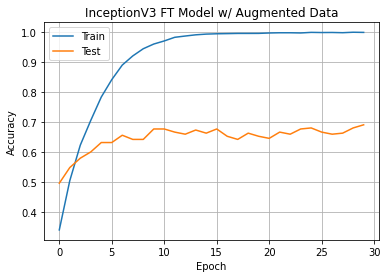

In [ ]:
plot_accuracy(model_4_hist, "InceptionV3 FT Model w/ Augmented Data")

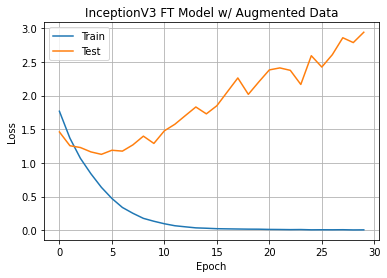

In [ ]:
plot_loss(model_4_hist, "InceptionV3 FT Model w/ Augmented Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_4 - start_time_model_4), "\n")

Elapsed Training Time: 4081.2939937114716 seconds 



In [ ]:
model_4.evaluate(test_imgs_scaled, y_test)

9/9 [==============================] - 3s 310ms/step - loss: 2.9411 - accuracy: 0.6910


[2.941124677658081, 0.6909722089767456]

In [ ]:
y_pred_model_4 = get_predictions(test_imgs_scaled, model_4, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_4, encoder)

              precision    recall  f1-score   support

       Angry       0.58      0.80      0.67        35
        Calm       0.70      0.97      0.81        36
     Disgust       0.75      0.69      0.72        39
        Fear       0.92      0.60      0.73        40
       Happy       0.61      0.61      0.61        36
     Neutral       0.68      0.54      0.60        24
         Sad       0.56      0.47      0.51        38
    Surprise       0.78      0.80      0.79        40

    accuracy                           0.69       288
   macro avg       0.70      0.69      0.68       288
weighted avg       0.70      0.69      0.69       288



In [ ]:
model_4.save("/content/drive/My Drive/Thesis/InceptionV3_FT_Aug_Data.h5")

# Xception Model Deployment with Fine Tuning
---

In [ ]:
xception = Xception(weights = "imagenet", include_top = False, input_shape = train_imgs[0].shape)

output = xception.layers[-1].output
output = Flatten()(output)
xception_model = Model(xception.input, output)

xception_model.trainable = True

layer_num = len(xception_model.layers)
for i, layer in enumerate(xception_model.layers):
        if i < 15:
            layer.trainable = False
        else:
            layer.trainable = True

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in xception_model.layers]
df = pd.DataFrame(layers, columns = ["Layer Type", "Layer Name", "Layer Trainable"])
df

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_2,False
1,<keras.layers.convolutional.Conv2D object at 0...,block1_conv1,False
2,<keras.layers.normalization.batch_normalizatio...,block1_conv1_bn,False
3,<keras.layers.core.Activation object at 0x7f90...,block1_conv1_act,False
4,<keras.layers.convolutional.Conv2D object at 0...,block1_conv2,False
...,...,...,...
128,<keras.layers.core.Activation object at 0x7f90...,block14_sepconv1_act,True
129,<keras.layers.convolutional.SeparableConv2D ob...,block14_sepconv2,True
130,<keras.layers.normalization.batch_normalizatio...,block14_sepconv2_bn,True
131,<keras.layers.core.Activation object at 0x7f90...,block14_sepconv2_act,True


In [ ]:
model_5 = Sequential()
input_shape = xception_model.output_shape[1]

model_5.add(xception_model)
model_5.add(Dense(512, activation = "relu", input_dim = input_shape))
model_5.add(Dropout(.3))
model_5.add(Dense(512, activation = "relu"))
model_5.add(Dropout(.3))
model_5.add(Dense(256, activation = "relu"))
model_5.add(Dropout(.3))
model_5.add(Dense(8, activation = "softmax"))

model_5.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])
model_5.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 157696)            20861480  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               80740864  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_5 = time.time()

model_5_hist = model_5.fit(x = train_imgs_scaled, y = y_train, batch_size = 32, epochs = 30, validation_data = (test_imgs_scaled, y_test), verbose = 1)

end_time_model_5 = time.time()

Epoch 1/30
288/288 [==============================] - 906s 3s/step - loss: 1.7091 - accuracy: 0.3581 - val_loss: 1.2957 - val_accuracy: 0.5243
Epoch 2/30
288/288 [==============================] - 891s 3s/step - loss: 1.1757 - accuracy: 0.5796 - val_loss: 1.0620 - val_accuracy: 0.6146
Epoch 3/30
288/288 [==============================] - 891s 3s/step - loss: 0.7918 - accuracy: 0.7205 - val_loss: 0.9147 - val_accuracy: 0.6667
Epoch 4/30
288/288 [==============================] - 893s 3s/step - loss: 0.5001 - accuracy: 0.8290 - val_loss: 0.9763 - val_accuracy: 0.7014
Epoch 5/30
288/288 [==============================] - 894s 3s/step - loss: 0.2933 - accuracy: 0.9026 - val_loss: 0.9761 - val_accuracy: 0.7153
Epoch 6/30
288/288 [==============================] - 895s 3s/step - loss: 0.1634 - accuracy: 0.9479 - val_loss: 1.1620 - val_accuracy: 0.6875
Epoch 7/30
288/288 [==============================] - 895s 3s/step - loss: 0.0880 - accuracy: 0.9724 - val_loss: 1.3886 - val_accuracy: 0.7083

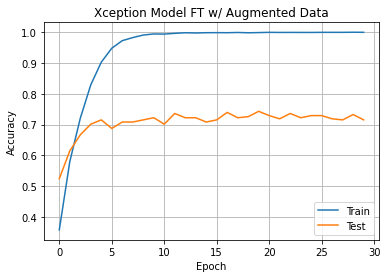

In [ ]:
plot_accuracy(model_5_hist, "Xception Model FT w/ Augmented Data")

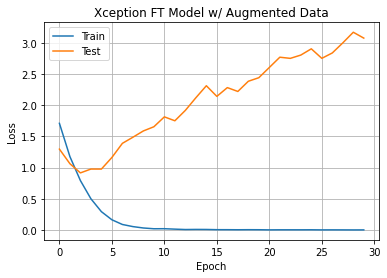

In [ ]:
plot_loss(model_5_hist, "Xception FT Model w/ Augmented Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_5 - start_time_model_5), "\n")

Elapsed Training Time: 26852.13182735443 seconds 



In [ ]:
model_5.evaluate(test_imgs_scaled, y_test)

9/9 [==============================] - 5s 536ms/step - loss: 3.0751 - accuracy: 0.7153


[3.075087547302246, 0.7152777910232544]

In [ ]:
y_pred_model_5 = get_predictions(test_imgs_scaled, model_5, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_5, encoder)

              precision    recall  f1-score   support

       Angry       0.73      0.69      0.71        35
        Calm       0.75      0.92      0.83        36
     Disgust       0.70      0.79      0.75        39
        Fear       0.72      0.70      0.71        40
       Happy       0.70      0.53      0.60        36
     Neutral       0.67      0.67      0.67        24
         Sad       0.54      0.53      0.53        38
    Surprise       0.88      0.88      0.88        40

    accuracy                           0.72       288
   macro avg       0.71      0.71      0.71       288
weighted avg       0.71      0.72      0.71       288



In [ ]:
model_5.save("/content/drive/My Drive/Thesis/Xception_FT_Aug_Data.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# ResNet-50 Model Deployment with Fine Tuning
---

In [ ]:
resnet = ResNet50(weights = "imagenet", include_top = False, input_shape = train_imgs[0].shape)

output = resnet.layers[-1].output
output = Flatten()(output)
resnet_model = Model(resnet.input, output)

resnet_model.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in resnet_model.layers]
df = pd.DataFrame(layers, columns = ["Layer Type", "Layer Name", "Layer Trainable"])
df

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_3,False
1,<keras.layers.convolutional.ZeroPadding2D obje...,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0...,conv1_conv,False
3,<keras.layers.normalization.batch_normalizatio...,conv1_bn,False
4,<keras.layers.core.Activation object at 0x7f90...,conv1_relu,False
...,...,...,...
171,<keras.layers.convolutional.Conv2D object at 0...,conv5_block3_3_conv,False
172,<keras.layers.normalization.batch_normalizatio...,conv5_block3_3_bn,False
173,<keras.layers.merge.Add object at 0x7f90bac16090>,conv5_block3_add,False
174,<keras.layers.core.Activation object at 0x7f90...,conv5_block3_out,False


In [ ]:
model_6 = Sequential()
input_shape = resnet_model.output_shape[1]

model_6.add(resnet_model)
model_6.add(Dense(512, activation = "relu", input_dim = input_shape))
model_6.add(Dropout(.3))
model_6.add(Dense(512, activation = "relu"))
model_6.add(Dropout(.3))
model_6.add(Dense(256, activation = "relu"))
model_6.add(Dropout(.3))
model_6.add(Dense(8, activation = "softmax"))

model_6.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])
model_6.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 157696)            23587712  
_________________________________________________________________
dense_8 (Dense)              (None, 512)               80740864  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_6 = time.time()

model_6_hist = model_6.fit(x = train_imgs_scaled, y = y_train, batch_size = 32, epochs = 30, validation_data = (test_imgs_scaled, y_test), verbose = 1)

end_time_model_6 = time.time()

Epoch 1/30
288/288 [==============================] - 211s 720ms/step - loss: 2.1159 - accuracy: 0.1316 - val_loss: 2.0695 - val_accuracy: 0.1285
Epoch 2/30
288/288 [==============================] - 205s 711ms/step - loss: 2.0733 - accuracy: 0.1429 - val_loss: 2.0716 - val_accuracy: 0.1215
Epoch 3/30
288/288 [==============================] - 205s 711ms/step - loss: 2.0666 - accuracy: 0.1337 - val_loss: 2.0658 - val_accuracy: 0.1215
Epoch 4/30
288/288 [==============================] - 206s 716ms/step - loss: 2.0580 - accuracy: 0.1389 - val_loss: 2.0578 - val_accuracy: 0.1215
Epoch 5/30
288/288 [==============================] - 205s 711ms/step - loss: 2.0493 - accuracy: 0.1408 - val_loss: 2.0453 - val_accuracy: 0.1215
Epoch 6/30
288/288 [==============================] - 206s 715ms/step - loss: 2.0381 - accuracy: 0.1449 - val_loss: 2.0358 - val_accuracy: 0.1215
Epoch 7/30
288/288 [==============================] - 206s 715ms/step - loss: 2.0219 - accuracy: 0.1564 - val_loss: 2.0173 -

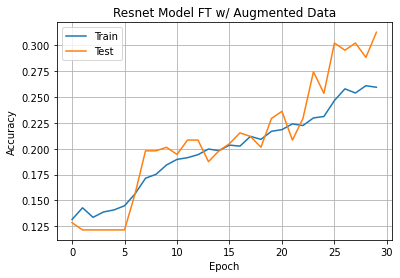

In [ ]:
plot_accuracy(model_6_hist, "Resnet Model FT w/ Augmented Data")

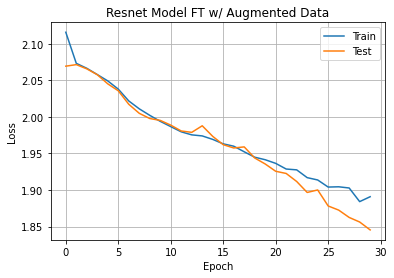

In [ ]:
plot_loss(model_6_hist, "Resnet Model FT w/ Augmented Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_6 - start_time_model_6), "\n")

Elapsed Training Time: 6134.876780509949 seconds 



In [ ]:
model_6.evaluate(test_imgs_scaled, y_test)

9/9 [==============================] - 5s 568ms/step - loss: 1.8454 - accuracy: 0.3125


[1.845375657081604, 0.3125]

In [ ]:
y_pred_model_6 = get_predictions(test_imgs_scaled, model_6, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_6, encoder)

              precision    recall  f1-score   support

       Angry       0.29      0.57      0.38        35
        Calm       0.28      0.61      0.38        36
     Disgust       0.39      0.67      0.50        39
        Fear       1.00      0.03      0.05        40
       Happy       0.25      0.11      0.15        36
     Neutral       0.00      0.00      0.00        24
         Sad       0.00      0.00      0.00        38
    Surprise       0.33      0.42      0.37        40

    accuracy                           0.31       288
   macro avg       0.32      0.30      0.23       288
weighted avg       0.34      0.31      0.24       288



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_6.save("/content/drive/My Drive/Thesis/Resnet_FT_Aug_Data.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# AlexNet
---


In [ ]:
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters = 96, input_shape = train_imgs[0].shape, kernel_size = (11,11), strides = (4, 4), padding = "same"))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters = 256, kernel_size = (5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(512, input_shape=train_imgs[0].shape))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(512))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(256))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(8))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 84, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 84, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 55, 84, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 42, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 42, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 42, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 42, 256)       0

In [ ]:
AlexNet.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
lrr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = .01, patience = 3, min_lr = 1e-5) 

In [ ]:
start_time_alexnet = time.time()

alexnet_hist = AlexNet.fit(x = train_imgs_scaled, y = y_train, batch_size = 32, epochs = 30, validation_data = (test_imgs_scaled, y_test), callbacks = [lrr], verbose = 1)

end_time_alexnet = time.time()

Epoch 1/30
288/288 [==============================] - 238s 819ms/step - loss: 1.6226 - accuracy: 0.4111 - val_loss: 2.8618 - val_accuracy: 0.2882
Epoch 2/30
288/288 [==============================] - 237s 821ms/step - loss: 1.0953 - accuracy: 0.6444 - val_loss: 1.4668 - val_accuracy: 0.5278
Epoch 3/30
288/288 [==============================] - 235s 817ms/step - loss: 0.7273 - accuracy: 0.7938 - val_loss: 1.0504 - val_accuracy: 0.6285
Epoch 4/30
288/288 [==============================] - 238s 826ms/step - loss: 0.5136 - accuracy: 0.8635 - val_loss: 1.0704 - val_accuracy: 0.6493
Epoch 5/30
288/288 [==============================] - 237s 824ms/step - loss: 0.3601 - accuracy: 0.9160 - val_loss: 1.3427 - val_accuracy: 0.5625
Epoch 6/30
288/288 [==============================] - 236s 821ms/step - loss: 0.2740 - accuracy: 0.9427 - val_loss: 1.0447 - val_accuracy: 0.6667
Epoch 7/30
288/288 [==============================] - 242s 840ms/step - loss: 0.2422 - accuracy: 0.9459 - val_loss: 1.1071 -

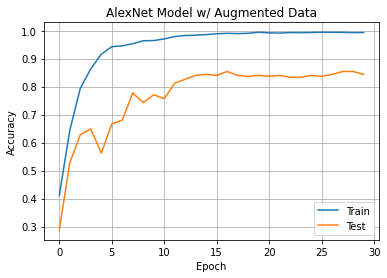

In [ ]:
plot_accuracy(alexnet_hist, "AlexNet Model w/ Augmented Data")

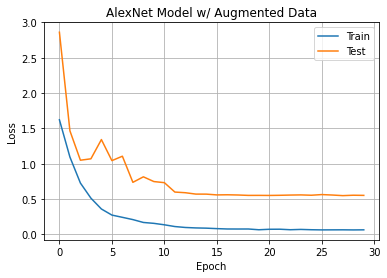

In [ ]:
plot_loss(alexnet_hist, "AlexNet Model w/ Augmented Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_alexnet - start_time_alexnet), "\n")

Elapsed Training Time: 7110.619213581085 seconds 



In [ ]:
AlexNet.evaluate(test_imgs_scaled, y_test)

9/9 [==============================] - 1s 132ms/step - loss: 0.5529 - accuracy: 0.8438


[0.5528600215911865, 0.84375]

In [ ]:
y_pred_alexnet = get_predictions(test_imgs_scaled, AlexNet, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_alexnet, encoder)

              precision    recall  f1-score   support

       Angry       0.77      0.86      0.81        35
        Calm       0.79      0.94      0.86        36
     Disgust       0.85      0.87      0.86        39
        Fear       0.91      0.75      0.82        40
       Happy       0.85      0.78      0.81        36
     Neutral       0.95      0.88      0.91        24
         Sad       0.78      0.76      0.77        38
    Surprise       0.90      0.93      0.91        40

    accuracy                           0.84       288
   macro avg       0.85      0.85      0.85       288
weighted avg       0.85      0.84      0.84       288



In [ ]:
AlexNet.save("/content/drive/My Drive/Thesis/AlexNet_Aug_Data2.h5")